In [1]:
%load_ext autoreload
%autoreload 2

# Moving Average with CNN

$\huge y_{N} = w_0 x_{N} + w_1x_{N-1} + ... + w_kx_{N-k}$

In [192]:
from scipy.signal import lfilter
from matplotlib import pyplot as plt

In [193]:
import numpy as np

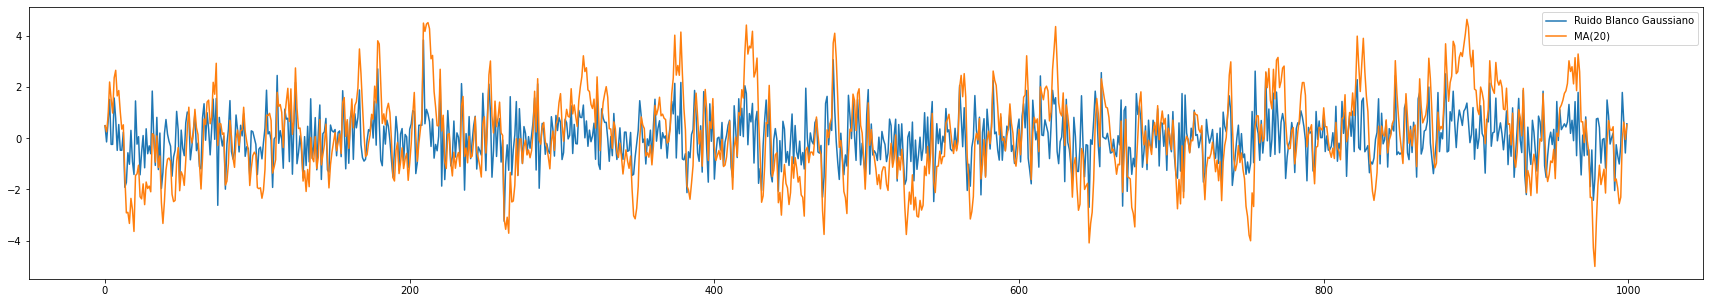

In [200]:
np.random.seed(42)
# filter_coefs = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
# filter_coefs = (filter_coefs/len(filter_coefs))
alpha = 0.8
N_coefs = 20
filter_coefs = np.power(alpha, np.abs(list(range(0, N_coefs)))) #[::-1]
X = np.random.normal(0, 1, 1000)
y_MA = lfilter(filter_coefs, [1], X)
plt.figure(figsize=(30, 5))
plt.plot(X, label='Ruido Blanco Gaussiano')
plt.plot(y_MA, label='MA(20)')
plt.legend()

In [214]:
0.8**4

0.4096000000000001

Text(0.5, 1.0, 'Respuesta al impulso MA(20)')

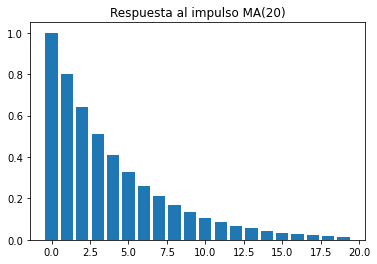

In [201]:
impulse = np.zeros(20)
impulse[0] = 1
impulse_response = lfilter(filter_coefs, [1], impulse)
plt.bar(range(len(impulse_response)), impulse_response)
plt.title('Respuesta al impulso MA(20)')

In [202]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D

In [236]:
def get_CNN_model(input_shape=(1000, 1), kernel_size=len(filter_coefs)):
    model = Sequential()
    model.add(Conv1D(filters=1, kernel_size=kernel_size, strides=1, input_shape=(1000, 1)))
    model.compile(optimizer='adam', loss='mse')
    return model

In [237]:
model_CNN = get_CNN_model()
model_CNN.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_17 (Conv1D)           (None, 981, 1)            21        
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


In [238]:
%%time
model_CNN.fit(X.reshape(1, -1, 1), y_MA[len(filter_coefs)-1:].reshape(1, -1, 1), epochs=3000, verbose=0)

CPU times: user 3.97 s, sys: 958 ms, total: 4.93 s
Wall time: 3.26 s


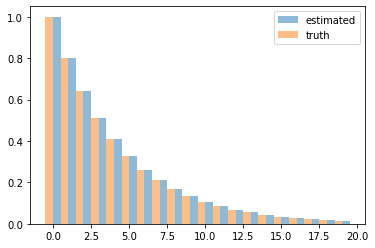

In [239]:
plt.bar(range(len(filter_coefs)), model_CNN.layers[0].get_weights()[0].flatten()[::-1], alpha=0.5, width=0.5, align='edge', label='estimated')
plt.bar(range(len(filter_coefs)), filter_coefs, alpha=0.5, width=-0.5, align='edge', label='truth')
plt.legend()

In [20]:
prediction_CNN = model_CNN.predict(X.reshape(1, -1, 1))

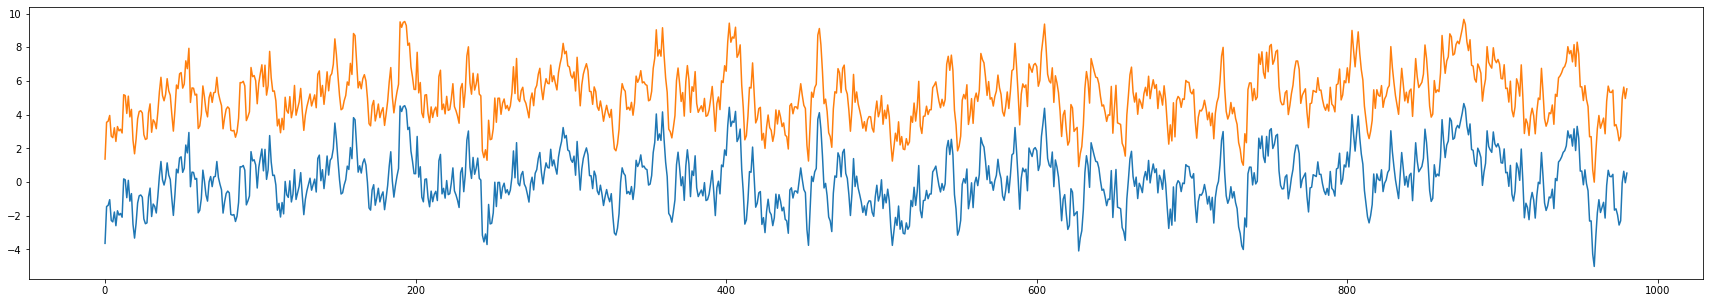

In [206]:
plt.figure(figsize=(30, 5))

plt.plot(y_MA[19:])
plt.plot(prediction_CNN.flatten() + 5)

# AR with RNN

$\huge y_{N} = 0.8y_{N-1} + x_{N}$

In [207]:
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense

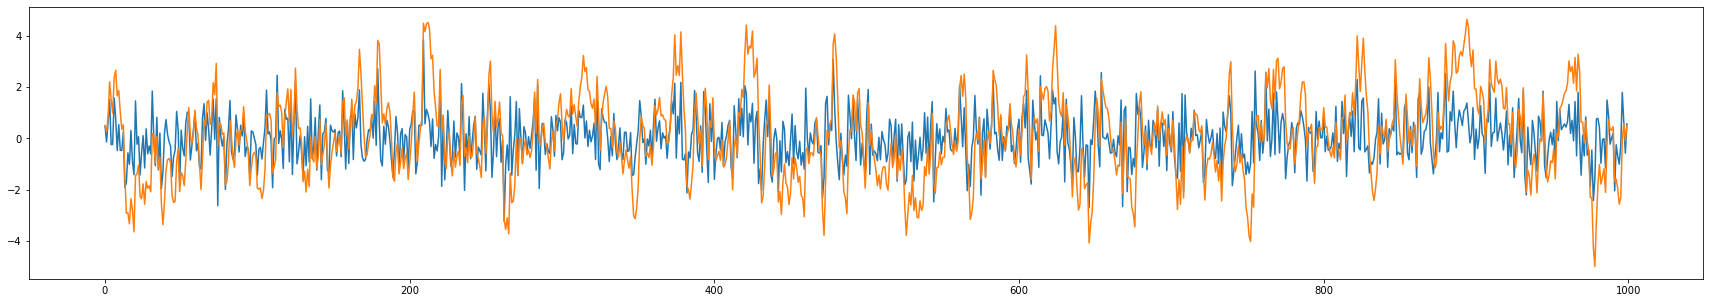

In [208]:
# np.random.seed(42)
# X = np.random.normal(0, 1, 1000)
y_AR1 = lfilter([1], [1, -alpha], X)
plt.figure(figsize=(30, 5))
plt.plot(X)
plt.plot(y_AR1)

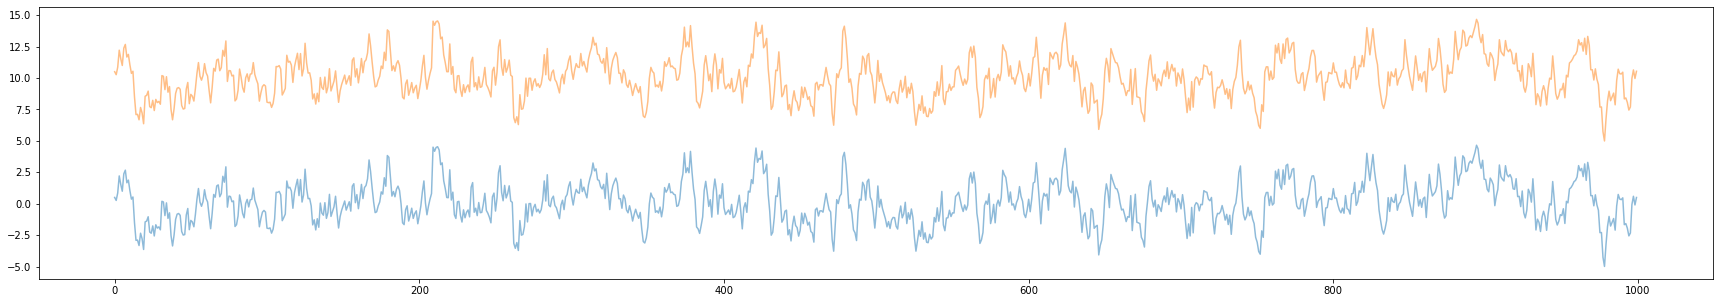

In [83]:
plt.figure(figsize=(30, 5))
plt.plot(y_AR1, alpha=0.5)
plt.plot(y_MA + 10, alpha=0.5)

Text(0.5, 1.0, 'Respuesta al impulso AR(1)')

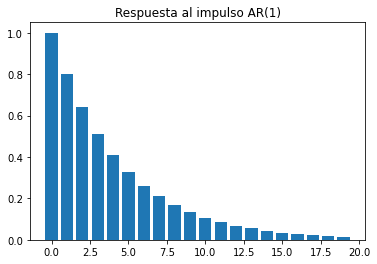

In [84]:
impulse = np.zeros(20)
impulse[0] = 1
plt.bar(range(len(impulse)), lfilter([1], [1, -alpha], impulse))
plt.title('Respuesta al impulso AR(1)')

In [220]:
def get_RNN_1():
    model_RNN_1 = Sequential()
    model_RNN_1.add(SimpleRNN(1, input_shape=(1000, 1), 
                              return_sequences=True, 
                              activation='linear', unroll=True))
    model_RNN_1.compile(optimizer='rmsprop', loss='mse')
    return model_RNN_1

In [221]:
model_RNN_1 = get_RNN_1()
model_RNN_1.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (None, 1000, 1)           3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [222]:
%%time
model_RNN_1.fit(X.reshape(1, -1, 1), y_AR1.reshape(1, -1, 1), 
                epochs=1, verbose=0)
# unroll=True Wall time: 30 s

CPU times: user 25.9 s, sys: 474 ms, total: 26.3 s
Wall time: 26.4 s


In [223]:
%%time
model_RNN_1.fit(X.reshape(1, -1, 1), y_AR1.reshape(1, -1, 1), 
                epochs=5000, verbose=0)
# unroll=True Wall time: 34.5 s

CPU times: user 1min 42s, sys: 10.9 s, total: 1min 53s
Wall time: 1min 17s


In [224]:
model_RNN_1.layers[0].get_weights()

[array([[1.0005078]], dtype=float32),
 array([[0.800494]], dtype=float32),
 array([0.00049764], dtype=float32)]

In [225]:
prediction_RNN_1 = model_RNN_1.predict(X.reshape(1, -1, 1)).flatten()

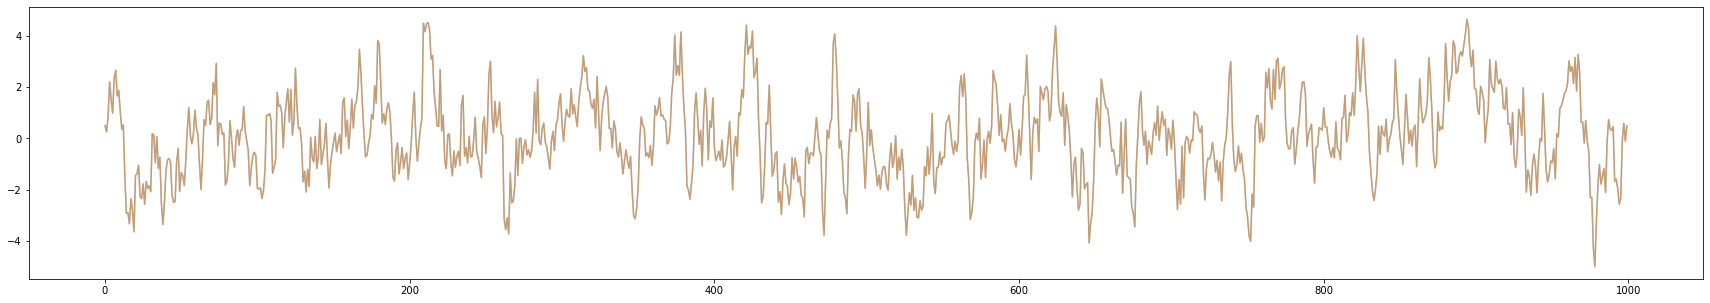

In [95]:
plt.figure(figsize=(30, 5))

plt.plot(y_AR1, alpha=0.5)
plt.plot(prediction_RNN_1, alpha=0.5)

# AR 2

$\huge y_{N} = 0.2y_{N-1} + 0.7y_{N-2} + x_{N}$

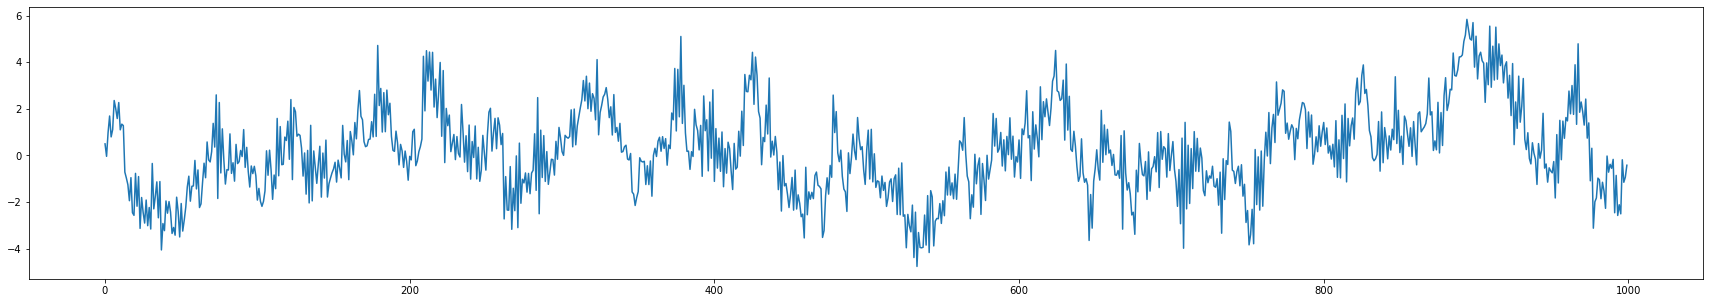

In [240]:
beta=0.1
y_AR2 = lfilter([1], [1, -0.2, -0.7], X)
plt.figure(figsize=(30, 5))
# plt.plot(X)
plt.plot(y_AR2)

Text(0.5, 1.0, 'Respuesta al impulso AR(2)')

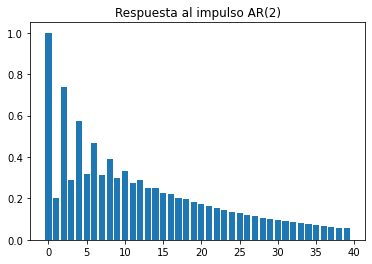

In [241]:
impulse = np.zeros(40)
impulse[0] = 1
plt.bar(range(len(impulse)), lfilter([1], [1, -0.2, -0.7], impulse))
plt.title('Respuesta al impulso AR(2)')

## Solved with CNN

In [138]:
filter_length = 20
model_CNN_AR = get_CNN_model(input_shape=(1000, 1), kernel_size=filter_length)
model_CNN_AR.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 981, 1)            21        
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


In [139]:
model_CNN_AR.fit(X.reshape(1, -1, 1), y_AR2[filter_length-1:].reshape(1, -1, 1), epochs=5000, verbose=0)

In [140]:
prediction_CNN_AR2 = model_CNN_AR.predict(X.reshape(1, -1, 1)).flatten()

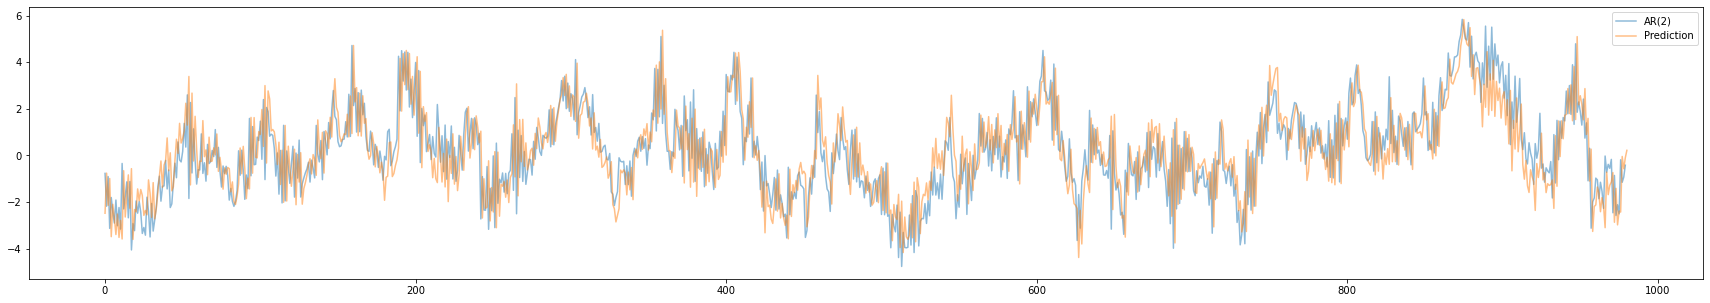

In [244]:
plt.figure(figsize=(30, 5))

plt.plot(y_AR2[filter_length:], alpha=0.5, label='AR(2)')
plt.plot(prediction_CNN_AR2, alpha=0.5, label='Prediction')
plt.legend()

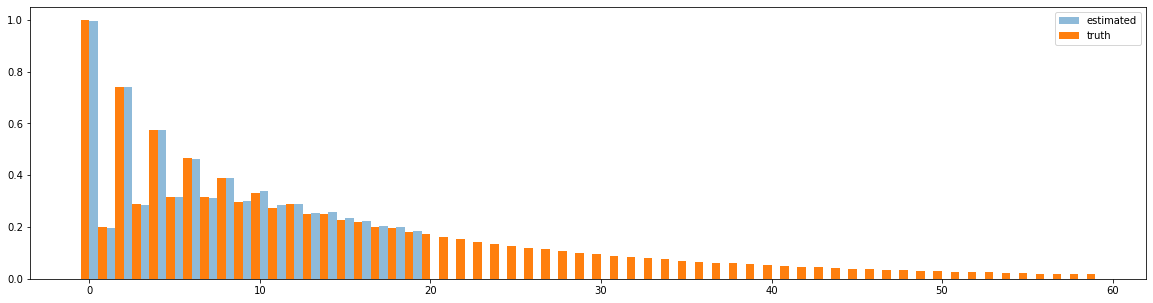

In [243]:
plt.figure(figsize=(20, 5))
plt.bar(range(filter_length), model_CNN_AR.layers[0].get_weights()[0].flatten()[::-1], alpha=0.5, width=0.5, align='edge', label='estimated')
impulse = np.zeros(60)
impulse[0] = 1
plt.bar(range(len(impulse)), lfilter([1], [1, -0.2, -0.7], impulse), width=-0.5, align='edge', label='truth')
plt.legend()

# Solved with RNN Anterior

In [264]:
model_RNN_1 = get_RNN_1()
model_RNN_1.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_5 (SimpleRNN)     (None, 1000, 1)           3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [265]:
model_RNN_1.fit(X.reshape(1, -1, 1), y_AR2.reshape(1, -1, 1), epochs=1, verbose=0)

In [266]:
%%time
model_RNN_1.fit(X.reshape(1, -1, 1), y_AR2.reshape(1, -1, 1), epochs=5000, verbose=0)

CPU times: user 1min 41s, sys: 11 s, total: 1min 52s
Wall time: 1min 18s


In [267]:
model_RNN_1.layers[0].get_weights()

[array([[0.61945546]], dtype=float32),
 array([[0.93693584]], dtype=float32),
 array([0.00090128], dtype=float32)]

In [277]:
prediction_RNN_1_b = model_RNN_1.predict(X.reshape(1, -1, 1)).flatten()

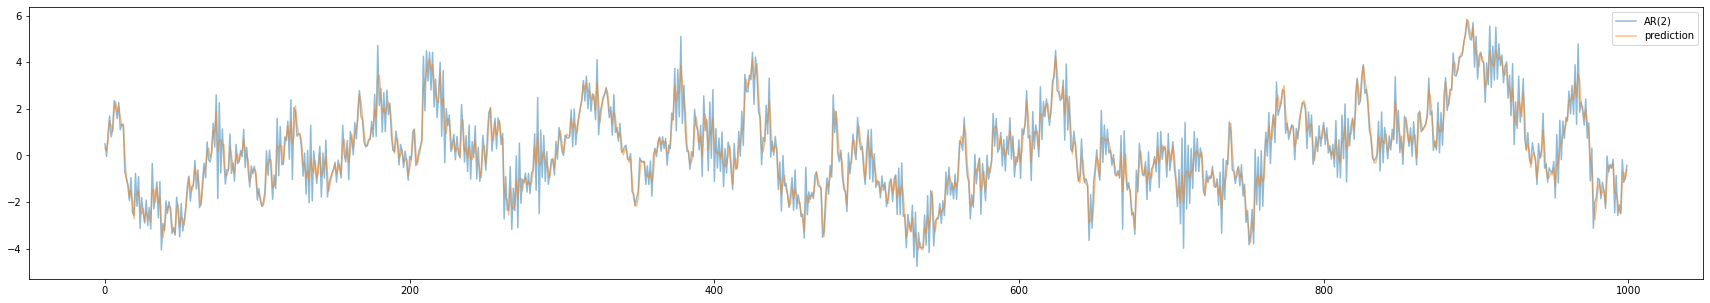

In [278]:
plt.figure(figsize=(30, 5))

plt.plot(y_AR2, alpha=0.5, label='AR(2)')
plt.plot(prediction_RNN_1_b, alpha=0.5, label='prediction')
plt.legend()

<BarContainer object of 60 artists>

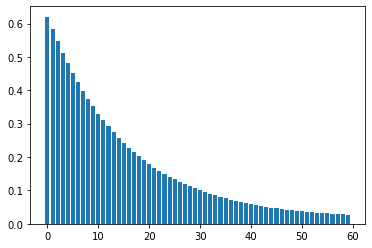

In [292]:
impulse = np.zeros(1000)
impulse[0] = 1
imp_resp_ar_1_2 = model_RNN_1.predict(impulse.reshape(1, -1, 1)).flatten()
plt.bar(range(60), imp_resp_ar_1_2[:60])

In [293]:
# impulse.reshape(1, -1, 1)

In [294]:
# model_RNN_1.predict(X.reshape(1, -1, 1))

## Agregado de neurona

In [297]:
model_RNN_2 = Sequential()
model_RNN_2.add(SimpleRNN(2, input_shape=(1000, 1), 
                          return_sequences=True, activation='linear', unroll=True))
model_RNN_2.add(Dense(1, activation='linear'))
model_RNN_2.compile(optimizer='rmsprop', loss='mse')

In [298]:
model_RNN_2.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_7 (SimpleRNN)     (None, 1000, 2)           8         
_________________________________________________________________
dense_2 (Dense)              (None, 1000, 1)           3         
Total params: 11
Trainable params: 11
Non-trainable params: 0
_________________________________________________________________


In [299]:
%%time
model_RNN_2.fit(X.reshape(1, -1, 1), y_AR2.reshape(1, -1, 1), epochs=5000, verbose=0)

CPU times: user 2min 19s, sys: 11.7 s, total: 2min 30s
Wall time: 1min 55s


In [300]:
model_RNN_2.get_weights()

[array([[0.78102076, 0.8557906 ]], dtype=float32),
 array([[ 0.9438502 ,  0.01475789],
        [-0.08329051, -0.7436993 ]], dtype=float32),
 array([0.00025409, 0.01026609], dtype=float32),
 array([[0.7538498],
        [0.4814792]], dtype=float32),
 array([0.00738907], dtype=float32)]

In [301]:
prediction_RNN_2 = model_RNN_2.predict(X.reshape(1, -1, 1)).flatten()

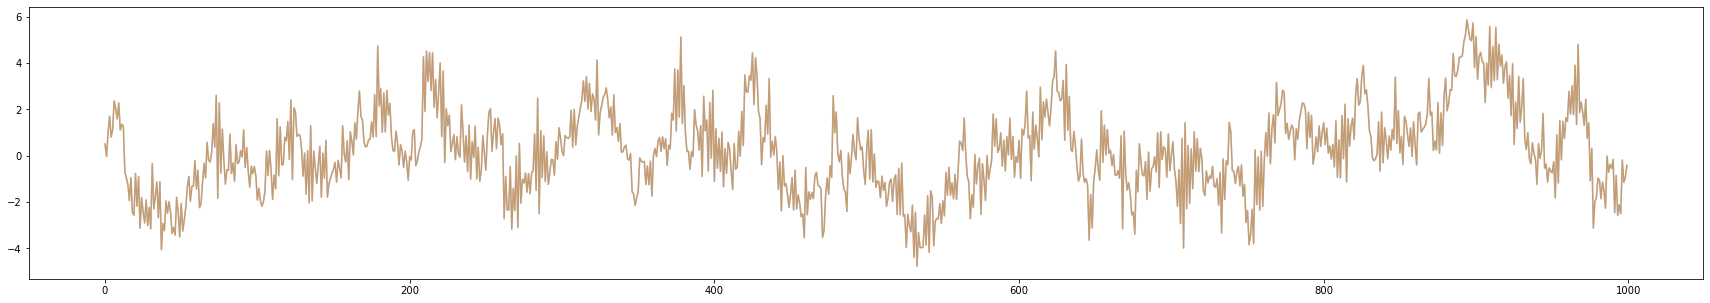

In [302]:
plt.figure(figsize=(30, 5))

plt.plot(y_AR2, alpha=0.5)
plt.plot(prediction_RNN_2, alpha=0.5)

<BarContainer object of 60 artists>

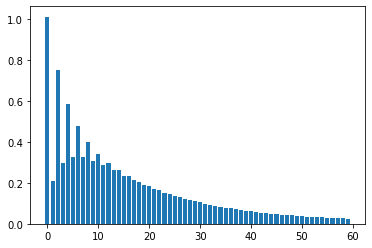

In [303]:
impulse = np.zeros(60)
impulse[0] = 1
imp_resp_ar_2_2 = model_RNN_2.predict(
    impulse.reshape(1, -1, 1)
).flatten()
plt.bar(range(len(imp_resp_ar_2_2)), imp_resp_ar_2_2)

## Stack de RNNs

In [315]:
model_stack = Sequential()
model_stack.add(SimpleRNN(1, input_shape=(1000, 1), 
                          return_sequences=True, 
                          activation='linear', 
                          unroll=True))
model_stack.add(SimpleRNN(1, return_sequences=True, 
                          activation='linear', 
                          unroll=True))
model_stack.compile(optimizer='rmsprop', loss='mse')

In [316]:
model_stack.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_12 (SimpleRNN)    (None, 1000, 1)           3         
_________________________________________________________________
simple_rnn_13 (SimpleRNN)    (None, 1000, 1)           3         
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________


In [317]:
%%time
model_stack.fit(X.reshape(1, -1, 1), y_AR2.reshape(1, -1, 1), epochs=1, verbose=0)

CPU times: user 1min 2s, sys: 987 ms, total: 1min 2s
Wall time: 1min 2s


In [325]:
%%time
model_stack.fit(X.reshape(1, -1, 1), y_AR2.reshape(1, -1, 1), epochs=2000, verbose=0)

CPU times: user 1min 28s, sys: 7.63 s, total: 1min 36s
Wall time: 1min 10s


In [326]:
model_stack.get_weights()

[array([[0.99177027]], dtype=float32),
 array([[-0.74207073]], dtype=float32),
 array([0.0657878], dtype=float32),
 array([[1.0094682]], dtype=float32),
 array([[0.9430844]], dtype=float32),
 array([-0.03732317], dtype=float32)]

In [327]:
prediction_RNN_stack = model_stack.predict(X.reshape(1, -1, 1)).flatten()

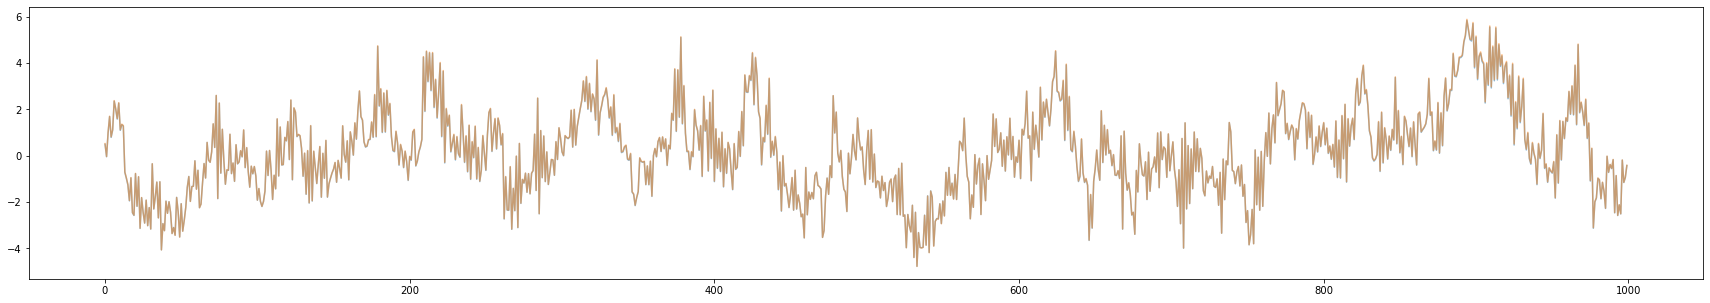

In [328]:
plt.figure(figsize=(30, 5))

plt.plot(y_AR2, alpha=0.5)
plt.plot(prediction_RNN_stack, alpha=0.5)

<BarContainer object of 60 artists>

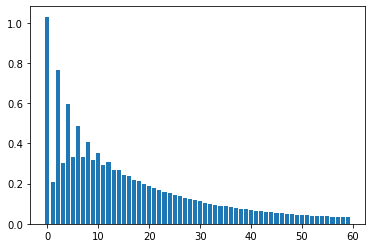

In [332]:
impulse = np.zeros(60)
impulse[0] = 1
imp_resp_ar_3_1 = model_stack.predict(impulse.reshape(1, -1, 1)).flatten()
plt.bar(range(len(imp_resp_ar_3_1)), imp_resp_ar_3_1)

In [ ]:
import numpy as np

In [166]:
X = [[1, 2, 3, 4, 5, 6], [2, 1, 3, 5, 1, 2]]


In [167]:
X

[[1, 2, 3, 4, 5, 6], [2, 1, 3, 5, 1, 2]]

In [ ]:
lista_total = np.vstack()

In [177]:
X = np.array(X).T
# X.reshape(-1, 2)

In [182]:
X.reshape(-1, 1)

array([[1],
       [2],
       [2],
       [1],
       [3],
       [3],
       [4],
       [5],
       [5],
       [1],
       [6],
       [2]])

In [191]:
np.array([1, 2, 3, 4, 5, 6, 2, 1, 3, 5, 1, 2]).reshape(-1, 2)

array([[1, 2],
       [3, 4],
       [5, 6],
       [2, 1],
       [3, 5],
       [1, 2]])